In [1]:
from RobustGNN.utils import *
from RobustGNN.Synthetic_Generator import synthData
from RobustGNN.models import DiffPool

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import networkx as nx
from networkx.generators.community import LFR_benchmark_graph as LFR
import clusim as clu

## PyG imports
import torch
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, GATConv
# from torch_geometric.utils.convert import to_networkx ,from_networkx
from torch_geometric.data import Data

from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim

In [2]:
# Test of robustness over varying scale parameter

frm=0
tu =100
byy=10
noise_vect = np.arange(frm,tu,byy)
N_runs = 5
N=1000 # num nodes
MU = 0.1 #Lfr param
FEAT_len = 32 #feature size

ECS_good= []
ECS_bad = []
std_good=[]
std_bad =[]



for NOISE in tqdm(noise_vect):
    
    data = synthData(n = N,mu = MU,feat_len= FEAT_len,noise = NOISE)
    
    good_data = data.graph #gen good data
    
    bad_data = data.gen_LFR_bad() #gen bad data
    
    tempECS_good= []
    tempECS_bad = []
    
    for i in range(N_runs):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = DiffPool(good_data).to(device)
        good_data = good_data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        #training step
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            out, mc_l, o_l = model(good_data)
            loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])+ mc_l+o_l
            loss.backward()
            optimizer.step()
        #-------------------------------------------------------------------------------------
        #evaluating trained GCN on Good Data
        model.eval()
        pred_good,_,_ = model(good_data)
        pred_good = pred_good.argmax(dim = -1)
        ecs = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        # correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # acc = acc.numpy(force=True)
        ecs_good = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        tempECS_good.append(ecs_good)
        #--------------------------------------------------------------------------------------
        #evaluation trained GCN on BAD data
        bad_data = bad_data.to(device)
        #evaluation trained GCN on BAD data
        model.eval()
        pred_bad,_,_= model(bad_data)
        pred_bad = pred_bad.argmax(dim = -1)
        ecs_bad = compute_ecs(bad_data.test_mask,data.true_comms,
                          pred_bad)
        #Uncomment to see node classification accuracy
        # num_correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # # acc = acc.numpy(force=True)
        tempECS_bad.append(ecs_bad)
        # print(f'(---End run {i}---)')

    ECS_good.append(np.mean(tempECS_good))
    ECS_bad.append(np.mean(tempECS_bad))
    std_good.append(np.std(tempECS_good))
    std_bad.append(np.std(tempECS_bad))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\jaide\Python Scripts\GNN\RobustGNN\Synthetic_Generator.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.86s/it]


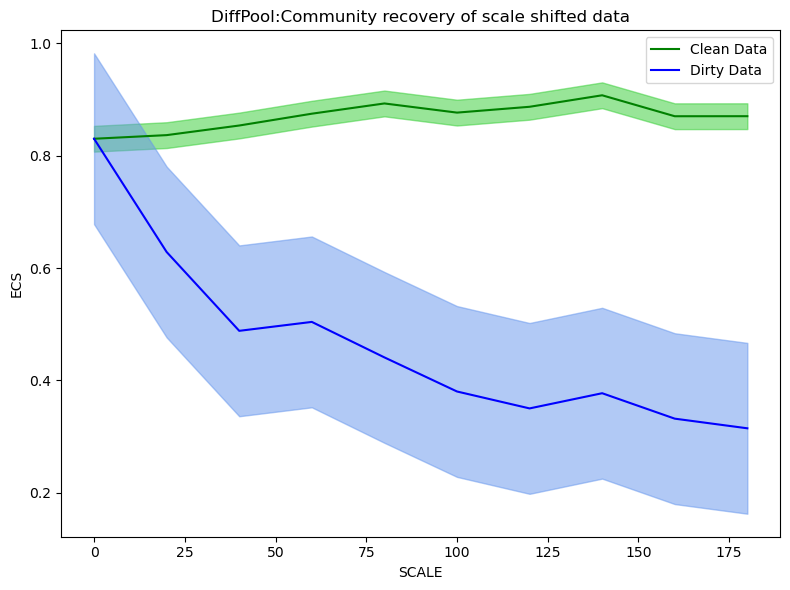

In [3]:
        
ECS_good=np.array(ECS_good)
ECS_bad =np.array(ECS_bad)
std_good =np.array(std_good)
std_bad =np.array(std_bad)

std_bad = np.std(ECS_bad)
std_good=np.std(ECS_good)
file_name = "C:/Users/jaide/Python Scripts/GNN/RobustGNN/Images/DiffPool/scale_shift.jpeg"
Title= "DiffPool:Community recovery of scale shifted data"
fig, ax = plt.subplots(figsize=(8,6))

x = noise_vect
ax.plot(x*2, ECS_good, color='green', label='Clean Data')
ax.fill_between(x*2, ECS_good - std_good, ECS_good+std_good,color='limegreen', alpha=0.5)

ax.plot(x*2, ECS_bad,color='blue', label='Dirty Data')
ax.fill_between(x*2, ECS_bad-std_bad, ECS_bad+std_bad,color='cornflowerblue', alpha=0.5)

plt.xlabel("SCALE")
plt.ylabel("ECS")
plt.title(Title)

ax.legend()
plt.savefig(file_name)
plt.tight_layout()
plt.show()

In [4]:
# Test of robustness over varying location parameter

frm= 0
tu= 20
byy=2
loc_vect = np.arange(frm,tu,byy)
N_runs = 5
N=1000 # num nodes
MU = 0.1 #Lfr param
FEAT_len = 32 #feature size

ECS_good= []
ECS_bad = []
std_good=[]
std_bad =[]



for LOC in tqdm(loc_vect):
    
    data = synthData(n = N,mu = MU,feat_len= FEAT_len,loc=LOC)
    
    good_data = data.graph #gen good data
    
    bad_data = data.gen_LFR_bad() #gen bad data
    
    tempECS_good= []
    tempECS_bad = []
    
    for i in range(N_runs):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = DiffPool(good_data).to(device)
        good_data = good_data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        #training step
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            out, ml_l, o_l = model(good_data)
            loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])+ml_l+o_l
            loss.backward()
            optimizer.step()
        #-------------------------------------------------------------------------------------
        #evaluating trained GCN on Good Data
        model.eval()
        pred_good,_,_ = model(good_data)
        pred_good = pred_good.argmax(dim = -1)
        ecs = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        # correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # acc = acc.numpy(force=True)
        ecs_good = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        tempECS_good.append(ecs_good)
        #--------------------------------------------------------------------------------------
        #evaluation trained GCN on BAD data
        bad_data = bad_data.to(device)
        #evaluation trained GCN on BAD data
        model.eval()
        pred_bad,_,_ = model(bad_data)
        pred_bad = pred_bad.argmax(dim=-1)
        
        ecs_bad = compute_ecs(bad_data.test_mask,data.true_comms,
                          pred_bad)
        #Uncomment to see node classification accuracy
        # num_correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # # acc = acc.numpy(force=True)
        tempECS_bad.append(ecs_bad)
        # print(f'(---End run {i}---)')

    ECS_good.append(np.mean(tempECS_good))
    ECS_bad.append(np.mean(tempECS_bad))
    std_good.append(np.std(tempECS_good))
    std_bad.append(np.std(tempECS_bad))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\jaide\Python Scripts\GNN\RobustGNN\Synthetic_Generator.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


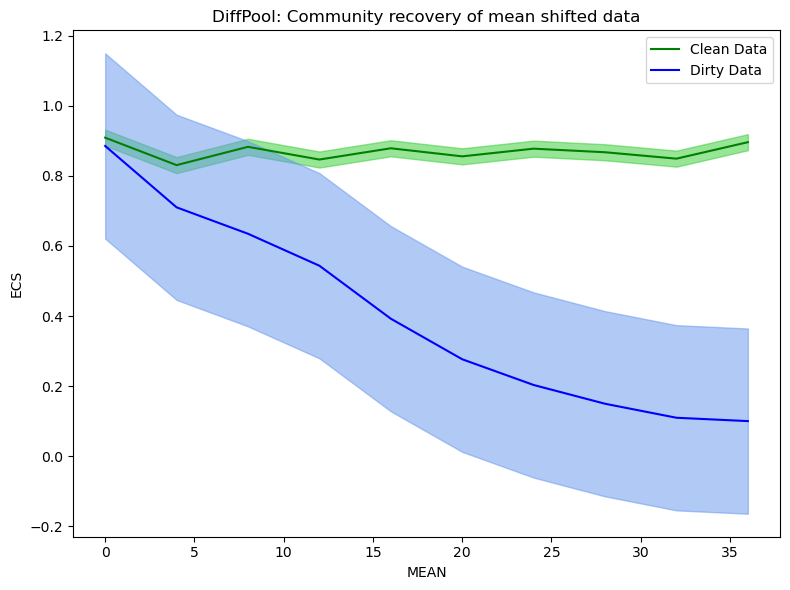

In [5]:
ECS_good=np.array(ECS_good)
ECS_bad =np.array(ECS_bad)
std_good =np.array(std_good)
std_bad =np.array(std_bad)

std_bad = np.std(ECS_bad)
std_good=np.std(ECS_good)
file_name = "C:/Users/jaide/Python Scripts/GNN/RobustGNN/Images/DiffPool/mean_shift.jpeg"
Title= "DiffPool: Community recovery of mean shifted data"
fig, ax = plt.subplots(figsize=(8,6))

# x = np.arange(len(ECS_good))
x=loc_vect
ax.plot(x*2, ECS_good, color='green', label='Clean Data')
ax.fill_between(x*2, ECS_good - std_good, ECS_good+std_good,color='limegreen', alpha=0.5)

ax.plot(x*2, ECS_bad,color='blue', label='Dirty Data')
ax.fill_between(x*2, ECS_bad-std_bad, ECS_bad+std_bad,color='cornflowerblue', alpha=0.5)

plt.xlabel("MEAN")
plt.ylabel("ECS")
plt.title(Title)

ax.legend()
plt.savefig(file_name)
plt.tight_layout()
plt.show()

In [6]:
# Test of robustness over varying feature

NOISE = 10
N_runs = 5
N=1000 # num nodes
MU = 0.1 #Lfr param
FEAT_len = 2**np.arange(4,10) #feature size

ECS_good= []
ECS_bad = []
std_good=[]
std_bad =[]



for FEAT in tqdm(FEAT_len):
    
    data = synthData(n = N,mu = MU,feat_len= FEAT,noise=NOISE)
    
    good_data = data.graph #gen good data
    
    bad_data = data.gen_LFR_bad() #gen bad data
    
    tempECS_good= []
    tempECS_bad = []
    
    for i in range(N_runs):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = DiffPool(good_data).to(device)
        good_data = good_data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        #training step
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            out, ml_l, o_l = model(good_data)
            loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])+ml_l+o_l
            loss.backward()
            optimizer.step()
        #-------------------------------------------------------------------------------------
        #evaluating trained GCN on Good Data
        model.eval()
        pred_good,_,_ = model(good_data)
        pred_good = pred_good.argmax(dim=-1)
        ecs = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        # correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # acc = acc.numpy(force=True)
        ecs_good = compute_ecs(good_data.test_mask,data.true_comms,
                          pred_good)
        tempECS_good.append(ecs_good)
        #--------------------------------------------------------------------------------------
        #evaluation trained GCN on BAD data
        bad_data = bad_data.to(device)
        #evaluation trained GCN on BAD data
        model.eval()
        pred_bad,_,_ = model(bad_data)
        pred_bad = pred_bad.argmax(dim= -1)
        ecs_bad = compute_ecs(bad_data.test_mask,data.true_comms,
                          pred_bad)
        #Uncomment to see node classification accuracy
        # num_correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        # acc = int(correct) / good_data.test_mask.sum()
        # print(f'ACCURACY: {acc}, RUN " {i}')
        # # acc = acc.numpy(force=True)
        tempECS_bad.append(ecs_bad)
        # print(f'(---End run {i}---)')

    ECS_good.append(np.mean(tempECS_good))
    ECS_bad.append(np.mean(tempECS_bad))
    std_good.append(np.std(tempECS_good))
    std_bad.append(np.std(tempECS_bad))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\jaide\Python Scripts\GNN\RobustGNN\Synthetic_Generator.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:35<00:00,  5.87s/it]


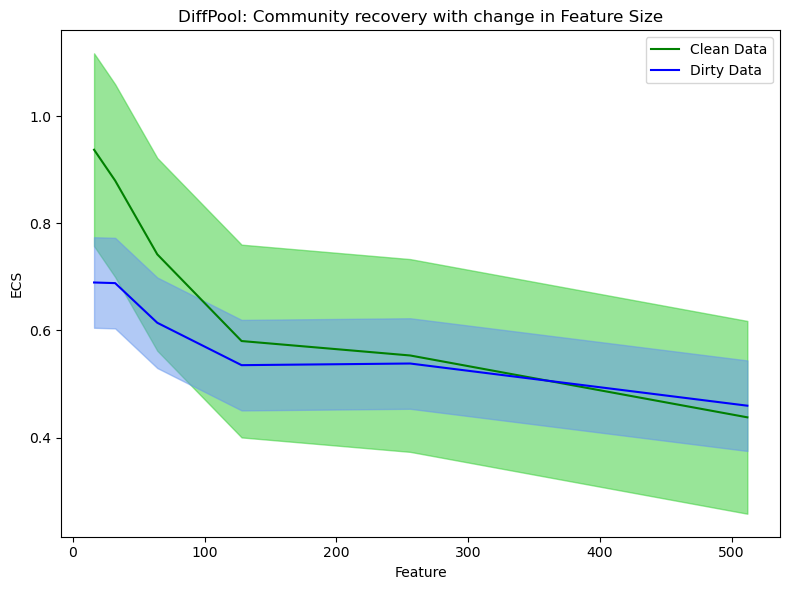

In [7]:
ECS_good=np.array(ECS_good)
ECS_bad =np.array(ECS_bad)
std_good =np.array(std_good)
std_bad =np.array(std_bad)

std_bad = np.std(ECS_bad)
std_good=np.std(ECS_good)
file_name = "C:/Users/jaide/Python Scripts/GNN/RobustGNN/Images/DiffPool/Feature_size_shift.jpeg"
Title= "DiffPool: Community recovery with change in Feature Size"
fig, ax = plt.subplots(figsize=(8,6))

x = 2**np.arange(4,10)
ax.plot(x, ECS_good, color='green', label='Clean Data')
ax.fill_between(x, ECS_good - std_good, ECS_good+std_good,color='limegreen', alpha=0.5)

ax.plot(x, ECS_bad,color='blue', label='Dirty Data')
ax.fill_between(x, ECS_bad-std_bad, ECS_bad+std_bad,color='cornflowerblue', alpha=0.5)

plt.xlabel("Feature")
plt.ylabel("ECS")
plt.title(Title)

ax.legend()
plt.savefig(file_name)
plt.tight_layout()
plt.show()

# TOPOLOGY PERTURBATIONS

### RANDOM EDGE DELETION 

In [15]:
N_runs = 50
N=1000 # num nodes
MU = 0.1 #Lfr param
FEAT_len = 32

data = synthData(n = N,mu = MU)

good_data = data.graph #gen good data
print(good_data.edge_index.shape)
bad_data = del_edges_randomly(good_data) #gen bad data
print(bad_data.edge_index.shape)
# good_data = del_edges_targetted(good_data)
# print(good_data.edge_index.shape)

tempECS_good= []
tempECS_bad = []
    
for i in tqdm(range(N_runs)):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DiffPool(good_data).to(device)
    good_data = good_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    #training step
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out, ml_l, o_l = model(good_data)
        loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])+ml_l+o_l
        loss.backward()
        optimizer.step()
    #-------------------------------------------------------------------------------------
    #evaluating trained GCN on Good Data
    model.eval()
    pred_good,_,_ = model(good_data)
    pred_good = pred_good.argmax(dim = -1)
    ecs = compute_ecs(good_data.test_mask,data.true_comms,
                      pred_good)
    # correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
    # acc = int(correct) / good_data.test_mask.sum()
    # print(f'ACCURACY: {acc}, RUN " {i}')
    # acc = acc.numpy(force=True)
    ecs_good = compute_ecs(good_data.test_mask,data.true_comms,
                      pred_good)
    tempECS_good.append(ecs_good)
    #--------------------------------------------------------------------------------------

    #training step
    model = DiffPool(bad_data).to(device)
    bad_data = bad_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out, ml_l, o_l = model(bad_data)
        loss = F.nll_loss(out[bad_data.train_mask], bad_data.y[bad_data.train_mask])+ml_l+o_l
        loss.backward()
        optimizer.step()
        
    #evaluation topology change DiffPool on BAD data
    model.eval()
    pred_bad,_,_ = model(bad_data)
    pred_bad = pred_bad.argmax(dim=-1)
    
    ecs_bad = compute_ecs(bad_data.test_mask,data.true_comms,
                      pred_bad)
    #Uncomment to see node classification accuracy
    # num_correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
    # acc = int(correct) / good_data.test_mask.sum()
    # print(f'ACCURACY: {acc}, RUN " {i}')
    # # acc = acc.numpy(force=True)
    tempECS_bad.append(ecs_bad)
    # print(f'(---End run {i}---)')

# ECS_good.append(np.mean(tempECS_good))
# ECS_bad.append(np.mean(tempECS_bad))
# std_good.append(np.std(tempECS_good))
# std_bad.append(np.std(tempECS_bad))

torch.Size([2, 35042])
(2, 27948)
torch.Size([2, 27948])


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


Mean 0.8382054737242635
Mean 0.7963377903995712


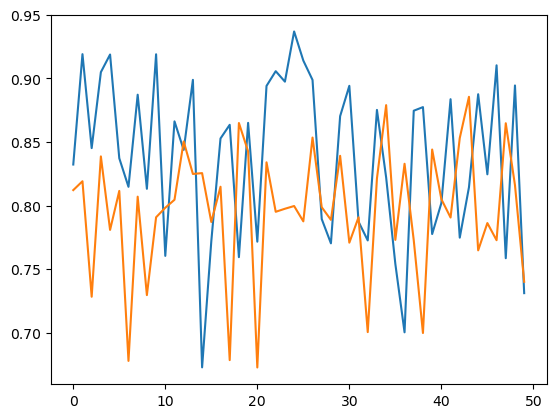

In [17]:
plt.plot(tempECS_good)
plt.plot(tempECS_bad)
print("Mean", np.mean(tempECS_good))
print("Mean", np.mean(tempECS_bad))

In [18]:
N_runs = 50
N=1000 # num nodes
MU = 0.1 #Lfr param
FEAT_len = 32

data = synthData(n = N,mu = MU)

good_data = data.graph #gen good data
print(good_data.edge_index.shape)
bad_data = del_edges_targetted(good_data) #gen bad data
print(bad_data.edge_index.shape)
# good_data = del_edges_targetted(good_data)
# print(good_data.edge_index.shape)

tempECS_good= []
tempECS_bad = []
    
for i in tqdm(range(N_runs)):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DiffPool(good_data).to(device)
    good_data = good_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    #training step
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out, ml_l, o_l = model(good_data)
        loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])+ml_l+o_l
        loss.backward()
        optimizer.step()
    #-------------------------------------------------------------------------------------
    #evaluating trained GCN on Good Data
    model.eval()
    pred_good,_,_ = model(good_data)
    pred_good = pred_good.argmax(dim = -1)
    ecs = compute_ecs(good_data.test_mask,data.true_comms,
                      pred_good)
    # correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
    # acc = int(correct) / good_data.test_mask.sum()
    # print(f'ACCURACY: {acc}, RUN " {i}')
    # acc = acc.numpy(force=True)
    ecs_good = compute_ecs(good_data.test_mask,data.true_comms,
                      pred_good)
    tempECS_good.append(ecs_good)
    #--------------------------------------------------------------------------------------

    #training step
    model = DiffPool(bad_data).to(device)
    bad_data = bad_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out, ml_l, o_l = model(bad_data)
        loss = F.nll_loss(out[bad_data.train_mask], bad_data.y[bad_data.train_mask])+ml_l+o_l
        loss.backward()
        optimizer.step()
        
    #evaluation topology change DiffPool on BAD data
    model.eval()
    pred_bad,_,_ = model(bad_data)
    pred_bad = pred_bad.argmax(dim=-1)
    
    ecs_bad = compute_ecs(bad_data.test_mask,data.true_comms,
                      pred_bad)
    #Uncomment to see node classification accuracy
    # num_correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
    # acc = int(correct) / good_data.test_mask.sum()
    # print(f'ACCURACY: {acc}, RUN " {i}')
    # # acc = acc.numpy(force=True)
    tempECS_bad.append(ecs_bad)
    # print(f'(---End run {i}---)')

# ECS_good.append(np.mean(tempECS_good))
# ECS_bad.append(np.mean(tempECS_bad))
# std_good.append(np.std(tempECS_good))
# std_bad.append(np.std(tempECS_bad))

torch.Size([2, 34788])
torch.Size([2, 20840])


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:37<00:00,  1.96s/it]


Mean 0.8619012138529762
Mean 0.7780481181250694


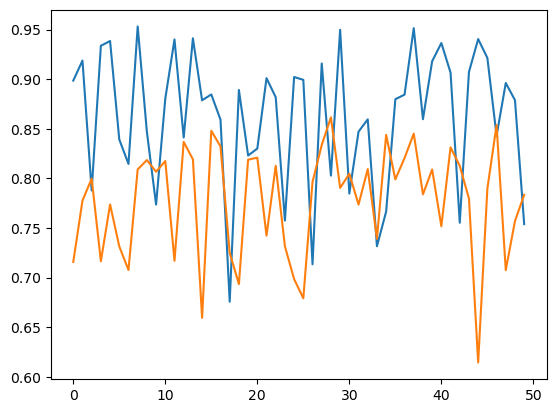

In [19]:
plt.plot(tempECS_good)
plt.plot(tempECS_bad)
print("Mean", np.mean(tempECS_good))
print("Mean", np.mean(tempECS_bad))